In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import h5py
from SuperpixelCutsPy import *
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [2]:
dataset_name = 'Salinas B'
hyperspectral_cube = sp.io.loadmat("data/Salinas_corrected.mat")['salinas_corrected'][35:90,0:175,:] # Load Dataset
ground_truth = sp.io.loadmat("data/Salinas_gt.mat")['salinas_gt'][35:90,0:175]
#ground_truth = np.vectorize(lambda x: {0: 0, 4:1, 5:2, 6:3, 7:4, 8:5, 15:6}[x])(ground_truth)
ground_truth = np.vectorize(lambda x: {0: 0, 4:1, 5:1, 6:2, 7:3, 8:4, 15:5}[x])(ground_truth)
nx, ny, nb = hyperspectral_cube.shape
print(hyperspectral_cube.shape)

(55, 175, 204)


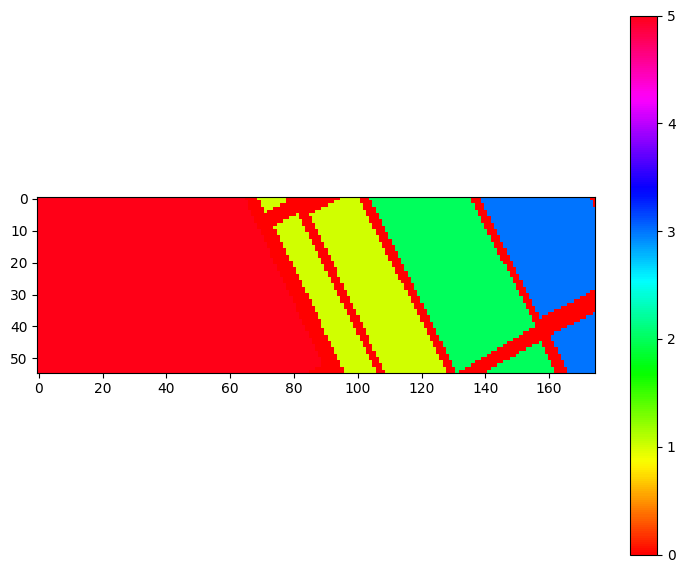

In [3]:
plt.imshow(ground_truth, cmap = "hsv")
plt.colorbar();

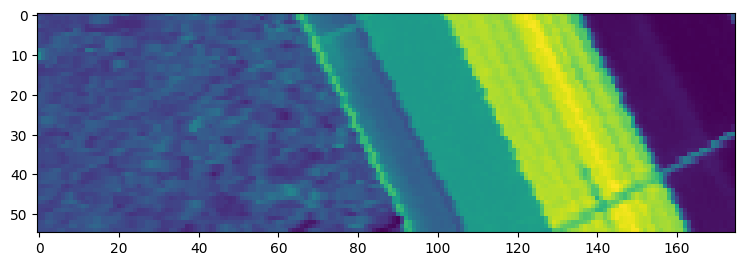

In [4]:
plt.imshow(hyperspectral_cube[:,:,30])

In [5]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 3)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()
# hyperspectral_cube = hyperspectral_cube[0:55,0:55,:]
# ground_truth = ground_truth[0:55,0:55]

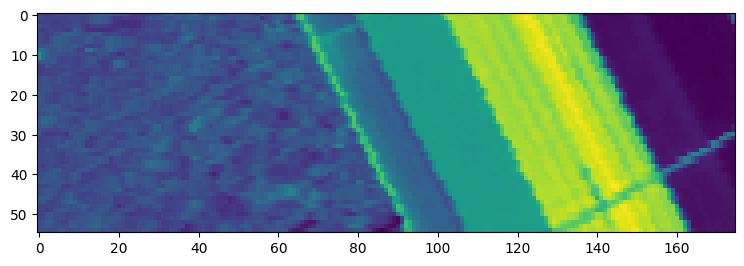

In [6]:
plt.imshow(hyperspectral_cube[:,:,30])

In [7]:
n_superpixels = 300 #2500
slic_m_param = 2  #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Adjusting n_superpixels: 385
Created 385 superpixels


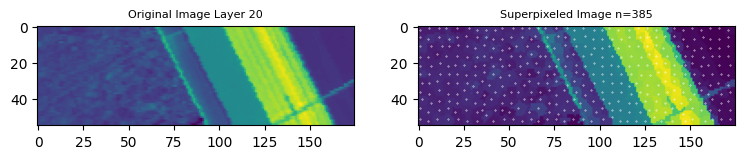

In [8]:
fig, ax = plt.subplots(1,2, dpi=100);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview]);
ax[1].imshow(superpixeled_cube[:,:,layer_preview])
ax[1].scatter(centers[:,1], centers[:,0], c='white', s=0.1);
ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

Initial Clustering
Spectral + Unmixing Clustering


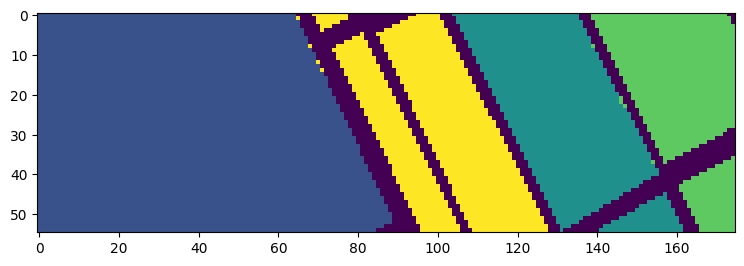

In [9]:
sigma_param = 0.05# 0.1 -> 0.001           #0.01
spatial_limit = 10# 15 -> 25 in steps of 5 #15
ne = 4#number of endmembers

superpixel_cluster_labels, mean_cluster_spectra = normalized_cuts.single_ncuts_admm(data=hyperspectral_cube,
                                                                                superpixel_library=superpixel_library,
                                                                                superpixel_centers=centers,
                                                                                superpixel_assignments=assignments,
                                                                                n_endmembers=ne,
                                                                                spectral_sigma2_param=sigma_param,
                                                                                spatial_kappa_param=spatial_limit,
                                                                                spectral_metric='SAM')

labelled_img = normalized_cuts.assign_labels_onto_image(assignments, superpixel_cluster_labels)

_, superpixel_original_library = superpixel.generate_SLIC_superpixels(data = original_hyperspectral_cube,
                                                                      assignments = assignments)

original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

plt.imshow((labelled_img+1)*(ground_truth != 0));

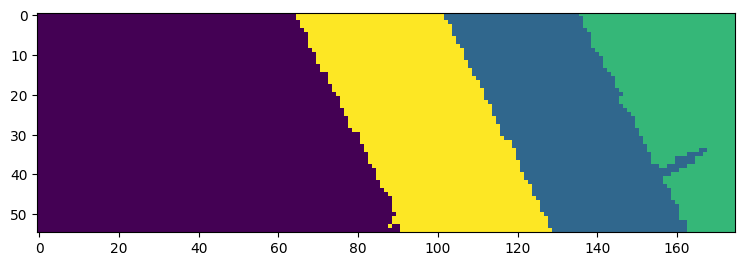

In [10]:
plt.imshow(labelled_img);

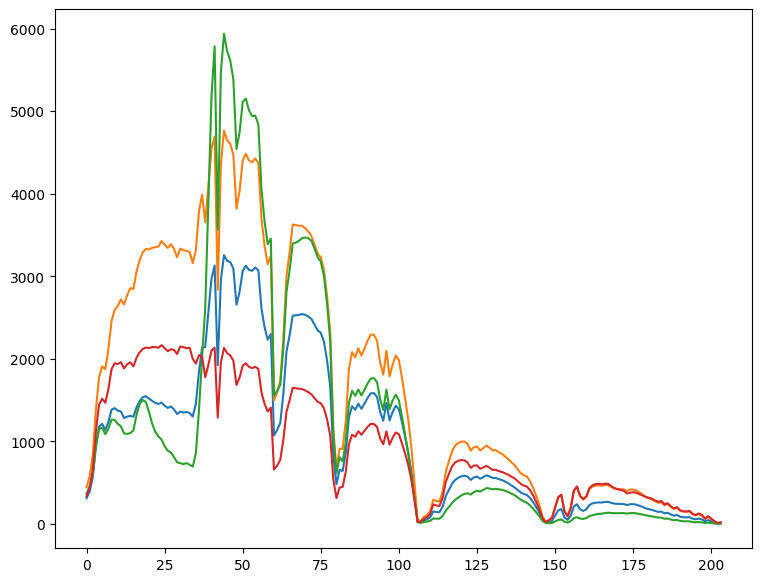

In [11]:
plt.plot(original_library);